In [1]:
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import cProfile
import emcee
import corner
import copy
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv

In [2]:
import matplotlib
font = {'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
test_sim_num=50
skewers_label='Ns256_wM0.05'
#skewers_label=None
basedir="/p1d_emulator/sim_suites/emulator_256_28082019/"
#basedir=repo+"/p1d_emulator/sim_suites/emulator_256_15072019/"
p1d_label=None
undersample_z=1
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
max_arxiv_size=None
kmax_Mpc=8
z_list=None

In [4]:
truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=truth.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<7]

In [5]:
## Now want to train an emulator on all 200 sims, and use those hyperparameters and
## param scalings to use 199 points and predict the 1 remaining
training_arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,drop_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [6]:
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=training_arxiv,kmax_Mpc=8,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 1592 points
Optimised


In [7]:
emu_rbf_only=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,kmax_Mpc=8,
                                emu_type="k_bin",passArxiv=training_arxiv,rbf_only=True,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

Training GP on 1592 points
Optimised


In [8]:
emu_rbf_ard=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,kmax_Mpc=8,
                                emu_type="k_bin",passArxiv=training_arxiv,rbf_only=True,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True,asymmetric_kernel=True)

Training GP on 1592 points
Optimised


In [9]:
emu_rbf_only.gp.param_array

array([3.67325175e+01, 5.67178912e-01, 2.17833037e-04])

In [10]:
emu.gp.param_array

array([2.85472086e+01, 2.27462355e+01, 5.34715678e-01, 2.04927884e-04])

In [11]:
emu_rbf_ard.gp.to_dict(save_data=False)

{'X': None,
 'Y': None,
 'class': 'GPy.models.GPRegression',
 'inference_method': {'class': 'GPy.inference.latent_function_inference.exact_gaussian_inference.ExactGaussianInference'},
 'kernel': {'ARD': True,
  'active_dims': [0, 1, 2, 3, 4, 5],
  'class': 'GPy.kern.RBF',
  'input_dim': 6,
  'inv_l': False,
  'lengthscale': [0.41764762204014794,
   0.41226903930128445,
   0.22464339987186369,
   0.4816193170736339,
   2.212761055864636,
   1.2657336552274503],
  'name': 'rbf',
  'useGPU': False,
  'variance': [21.07231607267695]},
 'likelihood': {'class': 'GPy.likelihoods.Gaussian',
  'gp_link_dict': {'class': 'GPy.likelihoods.link_functions.Identity'},
  'name': 'Gaussian_noise',
  'variance': [0.000129817994997137]},
 'name': 'GP regression'}

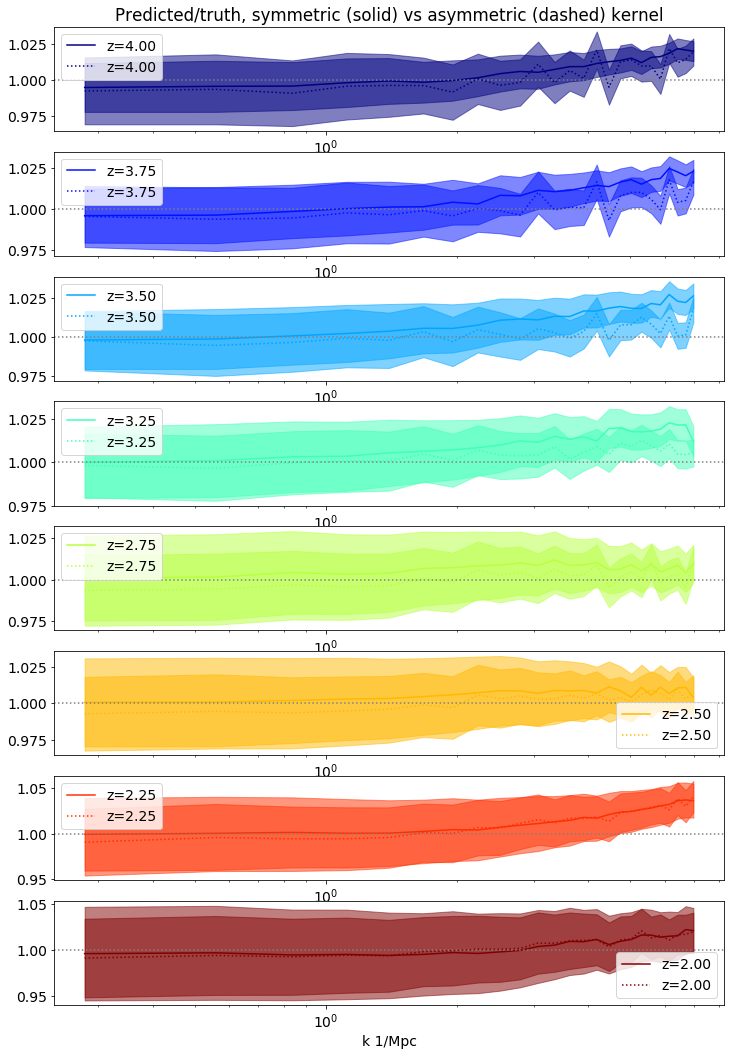

In [66]:
plt.figure(figsize=[12,18])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    if aa==0:
        plt.title("Predicted/truth, symmetric (solid) vs asymmetric (dashed) kernel")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_rbf,err_rbf=emu_rbf_only.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_rbf_ard,err_rbf_ard=emu_rbf_ard.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    ## Plot z with different limits
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    #plt.plot(k_test,pred_rbf/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="dashed",label="z=%.2f" % item["z"])
    #plt.fill_between(k_test,(pred_rbf+np.sqrt(np.diag(err_rbf)))/item["p1d_Mpc"][1:(len(k_test)+1)],
    #        (pred_rbf-np.sqrt(np.diag(err_rbf)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    plt.plot(k_test,pred_rbf_ard/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="dotted",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred_rbf_ard+np.sqrt(np.diag(err_rbf_ard)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred_rbf_ard-np.sqrt(np.diag(err_rbf_ard)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    plt.axhline(1,linestyle=":",color="gray")
    plt.xscale("log")
    plt.legend()

#plt.xscale("log")
plt.xlabel("k 1/Mpc")
plt.savefig("symmetric_vs_asymmetric.pdf")

In [15]:
## Check parameter limits
min_tau=min(training_arxiv.get_param_values("mF"))
max_tau=max(training_arxiv.get_param_values("mF"))

In [16]:
def value_from_cube(x,param):
    min_par=min(training_arxiv.get_param_values(param))
    max_par=max(training_arxiv.get_param_values(param))
    return min_par+x*(max_par-min_par)

def value_in_cube(x,param):
    min_par=min(training_arxiv.get_param_values(param))
    max_par=max(training_arxiv.get_param_values(param))
    return (x-min_par)/(max_par-min_par)

In [17]:
print("Correlation length in <F>", value_from_cube(0.5347156776712778,"mF"))
print("Correlation length in Delta2_p", value_from_cube(0.5347156776712778,"Delta2_p"))

Correlation length in <F> 0.58327786066558
Correlation length in Delta2_p 0.49536347085225435


In [58]:
## Need to compare this with some kind of derivative of the P1D
z_test=2.25
param="mF"
delta=0.1

thisz_only=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

## Remove all snaps outside of our chosen redshift
aa=0
while aa<len(thisz_only.data):
    if thisz_only.data[aa]["z"]!=z_test:
        del(thisz_only.data[aa])
    else:
        aa+=1

## Find median point at the given redshift
median_model={}
for par in paramList:    
    median_model[par]=np.median(np.asarray(thisz_only.get_param_values(par)))

## For a given emulator parameter, find the derivative of the p1d around the median value for that parameter
## Get delta_param from delta
delta_param=value_from_cube(0.5-delta,"mF")-value_from_cube(0.5,"mF")

model_plus=copy.deepcopy(median_model)
model_plus[param]=median_model[param]+delta_param

KeyboardInterrupt: 

In [59]:
delta=0.1

In [43]:
pred_median=(emu.emulate_p1d_Mpc(median_model,k_test,False,z_test)/emu.scalefactors[1:len(k_test)+1])-1
pred_plus=(emu.emulate_p1d_Mpc(model_plus,k_test,False,z_test)/emu.scalefactors[1:len(k_test)+1])-1

deriv=(pred_plus-pred_median)/delta_param

Text(0, 0.5, 'dP1d/d<F>')

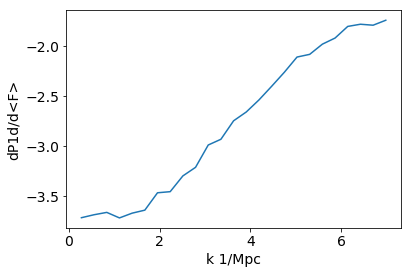

In [44]:
plt.plot(k_test,deriv)
plt.xlabel("k 1/Mpc")
plt.ylabel("dP1d/d<F>")

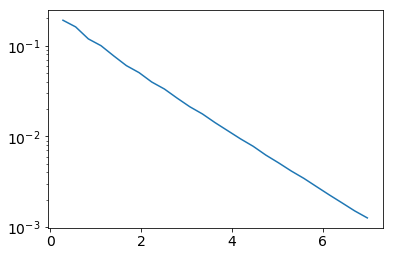

In [35]:
plt.plot(k_test,pred_median)
plt.yscale("log")

In [42]:
len(emu.scalefactors[1:len(k_test)+1])

25

In [38]:
len(k_test)

25

In [40]:
emu.training_k_bins

array([0.        , 0.27925268, 0.55850536, 0.83775804, 1.11701072,
       1.3962634 , 1.67551608, 1.95476876, 2.23402144, 2.51327412,
       2.7925268 , 3.07177948, 3.35103216, 3.63028484, 3.90953752,
       4.1887902 , 4.46804289, 4.74729557, 5.02654825, 5.30580093,
       5.58505361, 5.86430629, 6.14355897, 6.42281165, 6.70206433,
       6.98131701, 7.26056969, 7.53982237])

In [45]:
def get_p1d_derivative(z,param,emulator):
    thisz_only=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

    ## Remove all snaps outside of our chosen redshift
    aa=0
    while aa<len(thisz_only.data):
        if thisz_only.data[aa]["z"]!=z:
            del(thisz_only.data[aa])
        else:
            aa+=1

    ## Find median point at the given redshift
    median_model={}
    for par in paramList:    
        median_model[par]=np.median(np.asarray(thisz_only.get_param_values(par)))

    ## For a given emulator parameter, find the derivative of the p1d around the median value for that parameter
    ## Get delta_param from delta
    delta_param=value_from_cube(0.5-delta,param)-value_from_cube(0.5,param)

    model_plus=copy.deepcopy(median_model)
    model_plus[param]=median_model[param]+delta_param
    pred_median=(emulator.emulate_p1d_Mpc(median_model,k_test,False,z_test)/emulator.scalefactors[1:len(k_test)+1])-1
    pred_plus=(emulator.emulate_p1d_Mpc(model_plus,k_test,False,z_test)/emulator.scalefactors[1:len(k_test)+1])-1

    deriv=(pred_plus-pred_median)/delta_param
    return deriv

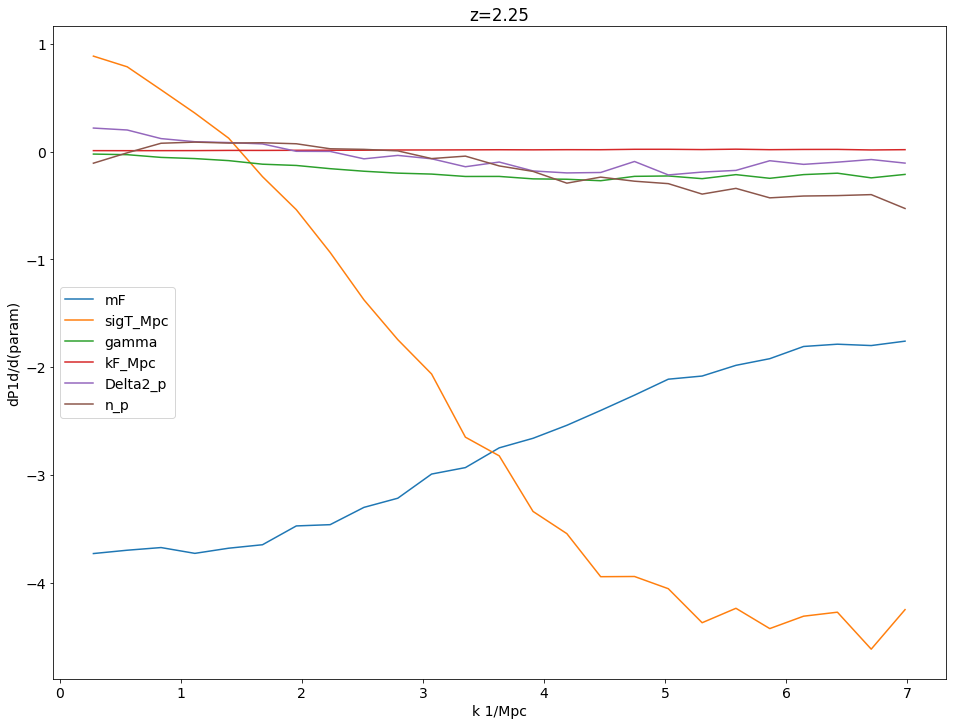

In [64]:
delta=0.01
z_plot=2.25
plt.figure(figsize=[16,12])
for par in paramList:
    derivs=get_p1d_derivative(z_plot,par,emu)
    #print(derivs)
    plt.plot(k_test,derivs,label="%s" % par)
plt.title("z=%.2f" % z_plot)
plt.xlabel("k 1/Mpc")
plt.ylabel("dP1d/d(param)")
plt.legend()
plt.savefig("derivs_z%.2f.pdf" % z_plot)

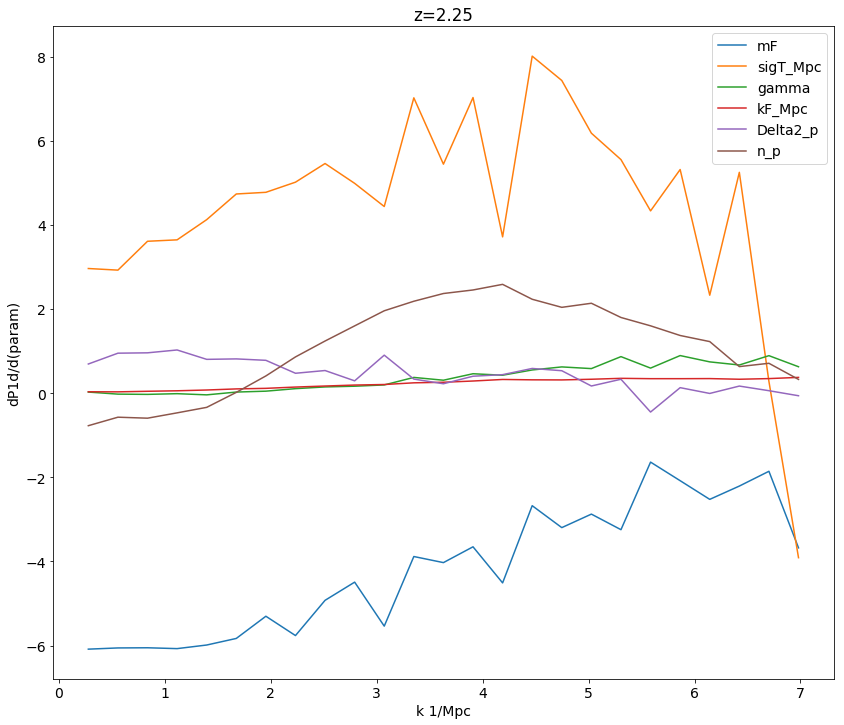

In [62]:
delta=0.01
z_plot=2.25
plt.figure(figsize=[14,12])
for par in paramList:
    derivs=get_p1d_derivative(z_plot,par,emu)
    plt.plot(k_test,derivs,label="%s" % par)
plt.title("z=%.2f" % z_plot)
plt.xlabel("k 1/Mpc")
plt.ylabel("dP1d/d(param)")
plt.legend()

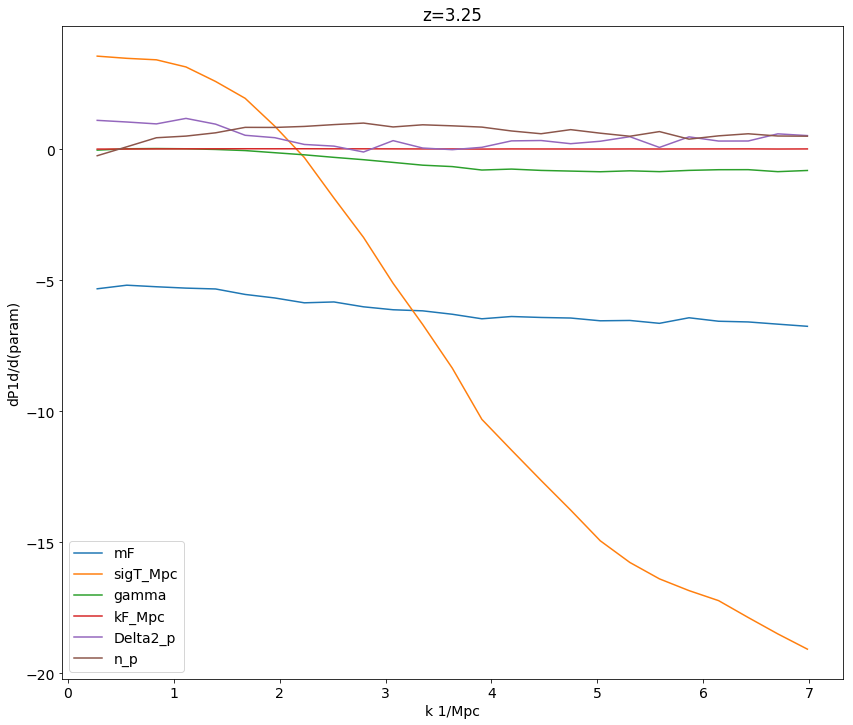

In [53]:
z_plot=3.25
plt.figure(figsize=[14,12])
for par in paramList:
    derivs=get_p1d_derivative(z_plot,par,emu)
    plt.plot(k_test,derivs,label="%s" % par)
plt.title("z=%.2f" % z_plot)
plt.xlabel("k 1/Mpc")
plt.ylabel("dP1d/d(param)")
plt.legend()

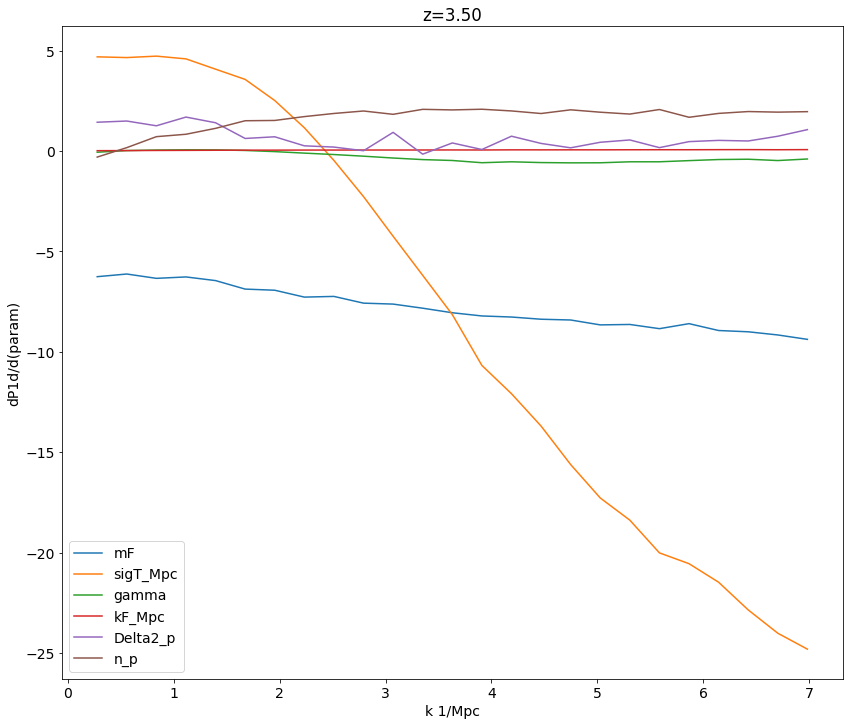

In [65]:
z_plot=3.5
plt.figure(figsize=[14,12])
for par in paramList:
    derivs=get_p1d_derivative(z_plot,par,emu)
    plt.plot(k_test,derivs,label="%s" % par)
plt.title("z=%.2f" % z_plot)
plt.xlabel("k 1/Mpc")
plt.ylabel("dP1d/d(param)")
plt.legend()
plt.savefig("derivs_z%.2f.pdf" % z_plot)

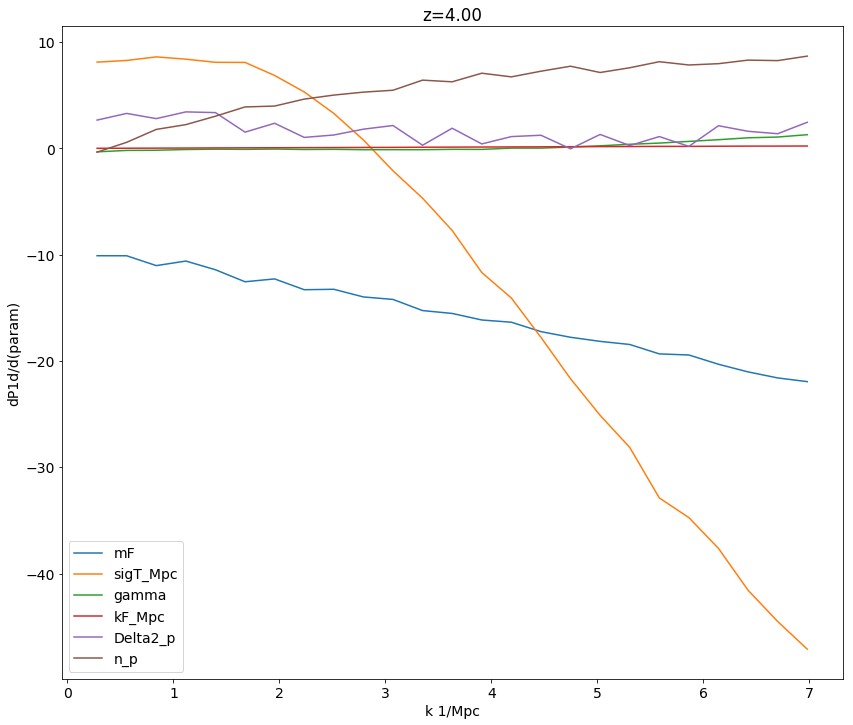

In [55]:
z_plot=4
plt.figure(figsize=[14,12])
for par in paramList:
    derivs=get_p1d_derivative(z_plot,par,emu)
    plt.plot(k_test,derivs,label="%s" % par)
plt.title("z=%.2f" % z_plot)
plt.xlabel("k 1/Mpc")
plt.ylabel("dP1d/d(param)")
plt.legend()

In [56]:
emu_rbf_ard.gp.to_dict(False)

{'X': None,
 'Y': None,
 'class': 'GPy.models.GPRegression',
 'inference_method': {'class': 'GPy.inference.latent_function_inference.exact_gaussian_inference.ExactGaussianInference'},
 'kernel': {'ARD': True,
  'active_dims': [0, 1, 2, 3, 4, 5],
  'class': 'GPy.kern.RBF',
  'input_dim': 6,
  'inv_l': False,
  'lengthscale': [0.41764762204014794,
   0.41226903930128445,
   0.22464339987186369,
   0.4816193170736339,
   2.212761055864636,
   1.2657336552274503],
  'name': 'rbf',
  'useGPU': False,
  'variance': [21.07231607267695]},
 'likelihood': {'class': 'GPy.likelihoods.Gaussian',
  'gp_link_dict': {'class': 'GPy.likelihoods.link_functions.Identity'},
  'name': 'Gaussian_noise',
  'variance': [0.000129817994997137]},
 'name': 'GP regression'}

In [57]:
emu_rbf_ard.paramList

['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']